<a href="https://colab.research.google.com/github/julianstrietzel/cisco-gold-mine/blob/main/traffic_cisco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import socket
import os
import sys
import math
from tqdm import tqdm
from IPython.display import Image, display

import folium
import matplotlib.pyplot as plt
import imageio

In [2]:
total_events_to_parse = 1000

In [3]:
def get_API_Key_and_auth():
    # Gets public key from spaces and places in correct format
    print("-- No API Key Found --")

    # Gets user to paste in generated token from app
    token = input('Enter provided API key here: ')

    # Writes activation key to file. This key can be used to open up Firehose connection
    f = open("API_KEY.txt", "a")
    f.write(token)
    f.close()
    return token

In [4]:

# work around to get IP address on hosts with non resolvable hostnames
s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
s.connect(("8.8.8.8", 80))
IP_ADRRESS = s.getsockname()[0]
s.close()
url = 'http://' + str(IP_ADRRESS) + '/update/'

# Tests to see if we already have an API Key
try:
    if os.stat("API_KEY.txt").st_size > 0:
        # If we do, lets use it
        f = open("API_KEY.txt")
        apiKey = f.read()
        f.close()
    else:
        # If not, lets get user to create one
        apiKey = get_API_Key_and_auth()
except:
    apiKey = get_API_Key_and_auth()

# overwrite previous log file
f = open("logs_device_location.json", 'w')
f.truncate(0)

# Opens a new HTTP session that we can use to terminate firehose onto
s = requests.Session()
s.headers = {'X-API-Key': apiKey}
r = s.get(
    'https://partners.dnaspaces.io/api/partners/v1/firehose/events', stream=True)  # Change this to .io if needed

# Jumps through every new event we have through firehose
print("Starting Stream")
device_location = 0
others = 0
total = total_events_to_parse
progressbar = tqdm(total=total)
data = dict()
for line in r.iter_lines():
    if line:
        # decodes payload into useable format
        decoded_line = line.decode('utf-8')
        event = json.loads(decoded_line)
        # filtering for relevant events and the correct scenario
        if event["partnerTenantId"] != "Simulation-Retail":
            continue
        eventType = event['eventType']
        if eventType != "DEVICE_LOCATION_UPDATE":
            continue
        data_line = json.loads(line)
        mac = data_line['deviceLocationUpdate']['device']['macAddress']
        # remove device information for efficiency
        data_line['deviceLocationUpdate']['device'] = "REMOVED"
        data_line['deviceLocationUpdate']['location'] = "REMOVED"
        # store paths of individuals according to their mac addresses
        if mac in data.keys():
            data[mac].append(data_line)
        else:
            data[mac] = [data_line]
        f.write(str(json.dumps(data_line)) + "\n")
        progressbar.update()
        device_location += 1
    if device_location > total:
        break
progressbar.display()
print("\nStream Ended")
f.close()
s.close()
paths_sorted_by_length = sorted(list(data.items()), key=lambda x: -len(x[1]))


Starting Stream


1001it [00:04, 424.25it/s]                         


Stream Ended


In [5]:
def calculate_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

In [6]:
# gets the ith longest path sorted by its timestamps
def get_sorted_path(index=0):
  longest_sorted_by_timestamp = sorted(paths_sorted_by_length[index][1], key = lambda x: x["recordTimestamp"])
  mac =  paths_sorted_by_length[index][0]
  steps = []
  last_record = None
  path = []

  for record in longest_sorted_by_timestamp:
      update = record["deviceLocationUpdate"]
      if last_record:
          # Calculate distance and time
          distance = calculate_distance(last_record["xPos"], last_record["yPos"], update["xPos"], update["yPos"])
          time_diff = (update["lastSeen"] - last_record["lastSeen"]) / 1000.0  # Convert milliseconds to seconds
          speed = distance / time_diff if time_diff > 0 else 0
          steps.append({"distance": distance, "time": time_diff, "speed": speed})
      path.append((update["xPos"], update["yPos"]))
      last_record = update

  # Extract start and end locations
  start_location = path[0]
  end_location = path[-1]
  return path, steps, start_location, end_location

In [7]:
path, steps, start, end = get_sorted_path()
print(f"Number of points on longest path: {len(path)}")

Number of points on longest path: 45


# You can calculate different information on path
As a basic example we calculate the average speed of an individual

In [8]:
def calculate_average_speed(steps):
    """
    Calculate the average speed over a path.

    Parameters:
    - steps (list of dicts): Each item contains 'distance' and 'time' for a step.

    Returns:
    - float: The average speed over the path.
    """
    total_distance = sum(step['distance'] for step in steps)
    total_time = sum(step['time'] for step in steps)

    if total_time > 0:  # Avoid division by zero
        average_speed = total_distance / total_time
        return average_speed
    else:
        return 0


In [9]:
f"The average speed for this customer {calculate_average_speed(steps)} m/s "

'The average speed for this customer 2.76490298256511 m/s '

In [10]:
def gen_plots(path, index=0):
  fig, ax = plt.subplots()
  ax.set_xlim(min(p[0] for p in path) - 1, max(p[0] for p in path) + 1)
  ax.set_ylim(min(p[1] for p in path) - 1, max(p[1] for p in path) + 1)
  plt.axis('off')  # Turn off the axis for a clean plot

  filenames = []

  # Draw each segment of the path and save each step as an image
  for i in range(1, len(path)):
      ax.plot([path[i-1][0], path[i][0]], [path[i-1][1], path[i][1]], color='blue')  # Draw line segment
      filename = f'frame_{i}_{index}.png'
      plt.savefig(filename, transparent=True)  # Save frame with transparent background
      filenames.append(filename)
  plt.close()
  return filenames

def gen_gif(path):
  filenames = gen_plots(path)
  with imageio.get_writer('path_animation.gif', mode='I', duration=4) as writer:  # Adjust duration as needed
      for filename in filenames:
          image = imageio.imread(filename)
          writer.append_data(image)
  display(Image(filename='path_animation.gif'))

<ipython-input-10-a4c92378683d>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


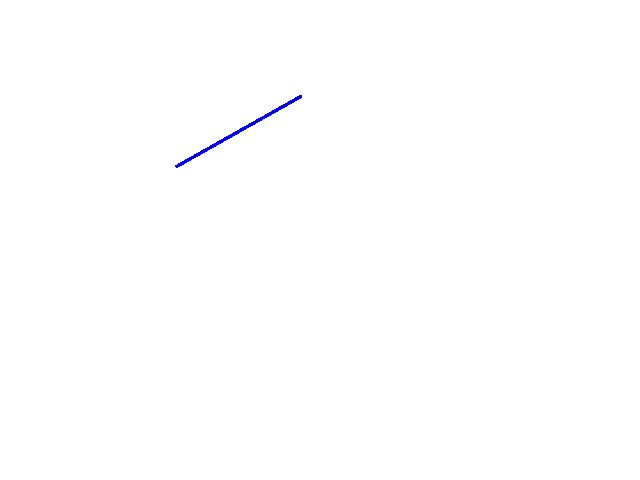

In [11]:
gen_gif(get_sorted_path(2)[0])


## Generating animation over several animated paths


 25%|██▌       | 5/20 [00:09<00:25,  1.73s/it]
1001it [00:19, 424.25it/s]
100%|██████████| 20/20 [00:22<00:00,  1.15s/it]

  0%|          | 0/334 [00:00<?, ?it/s]<ipython-input-12-3279678fab96>:50: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)

100%|██████████| 334/334 [00:02<00:00, 122.34it/s]


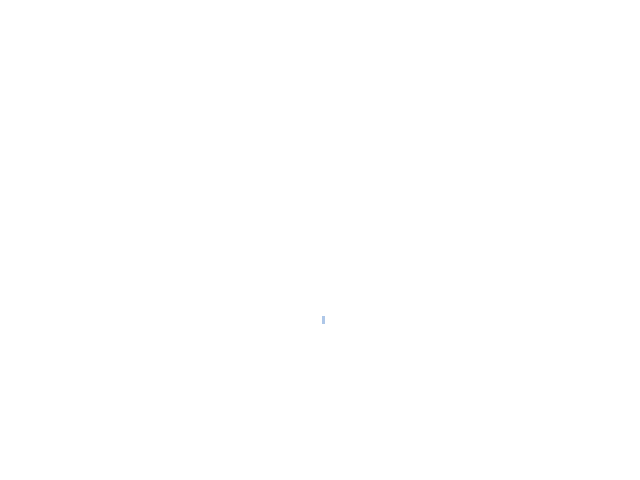

In [12]:
filenames = []
max_gifs = 20
colors = [
    '#aec7e8',  # Soft blue
    '#ffbb78',  # Soft orange
    '#98df8a',  # Pale green
    '#ff9896',  # Soft red
    '#c5b0d5',  # Soft purple
    '#c49c94',  # Rosy brown
    '#f7b6d2',  # Soft pink
    '#c7c7c7',  # Light gray
    '#dbdb8d',  # Mustard yellow
    '#9edae5',  # Soft teal
    '#1b9e77',  # Dark teal
    '#d95f02',  # Burnt orange
    '#7570b3',  # Dark lavender
    '#e7298a',  # Dark pink
    '#66a61e',  # Lime green
    '#e6ab02',  # Golden yellow
    '#a6761d',  # Bronze
    '#666666',  # Dark gray
    '#1a1a1a',  # Almost black
    '#f0027f'   # Bright pink
]
all_points = []
paths = []
for i in range(min(max_gifs, len(paths_sorted_by_length))):
  path = get_sorted_path(i)[0]
  if len(path) < 10:
    break
  paths.append(path)
  all_points.extend(paths[i])

fig, ax = plt.subplots()
ax.set_xlim(min(p[0] for p in all_points) - 1, max(p[0] for p in all_points) + 1)
ax.set_ylim(min(p[1] for p in all_points) - 1, max(p[1] for p in all_points) + 1)
plt.axis('off')  # Turn off the axis for a clean plot
filenames = []
for index in tqdm(range(min(max_gifs, len(paths)))):
  # Draw each segment of the path and save each step as an image
  path = paths[index]
  for i in range(1, len(path)):
      ax.plot([path[i-1][0], path[i][0]], [path[i-1][1], path[i][1]], color=colors[index % len(colors)])  # Draw line segment
      filename = f'frame_{index}_{i}.png'
      plt.savefig(filename, transparent=True)  # Save frame with transparent background
      filenames.append(filename)
plt.close()
with imageio.get_writer('total_paths_animation.gif', mode='I', duration=4) as writer:  # Adjust duration as needed
    for filename in tqdm(filenames):
        image = imageio.imread(filename)
        writer.append_data(image)
display(Image(filename='total_paths_animation.gif'))

In [13]:
def convert_to_geo(x, y, ref_lat = 40.712776, ref_lon = -74.005974): # Example: New York City
    meters_per_degree_lat = 111320
    meters_per_degree_lon = 111320 * math.cos(math.radians(ref_lat))

    delta_lat = y / meters_per_degree_lat
    delta_lon = x / meters_per_degree_lon

    return ref_lat + delta_lat, ref_lon + delta_lon


In [14]:
geo_path = [convert_to_geo(point[0], point[1], ) for point in path]

In [15]:
avg_lat = sum(p[0] for p in geo_path) / len(path)
avg_lon = sum(p[1] for p in geo_path) / len(path)
mymap = folium.Map(location=[avg_lat, avg_lon], zoom_start=14)

# Add a polyline to the map with the path
folium.PolyLine(path, color="blue", weight=2.5, opacity=1).add_to(mymap)

# Add markers for each step with popup information
for idx, ((xPos, yPos), step) in enumerate(zip(geo_path, steps), start=1):
    folium.Marker(
        (xPos, yPos),
        popup=f"Step {idx}: Distance {step['distance']:.2f}m, Time {step['time']:.2f}s, Speed {step['speed']:.2f}m/s",
    ).add_to(mymap)

# Save the map to an HTML file
display(mymap)